In [1]:
from tqdm import tqdm
import numpy as np
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from random import uniform
import bcolz
import time
from keras.layers import merge
from keras.layers.core import Lambda
from keras.models import Model
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers import Input, Dense
import math
import pandas as pd
from keras.utils import np_utils as u
import utils; reload(utils)
from utils import *
import gc

%matplotlib inline
%cd '/cp/home/ubuntu/intel'

Using Theano backend.


[Error 3] The system cannot find the path specified: u"'/cp/home/ubuntu/intel'"
C:\Users\chapanda\Documents\cp\Misc\Scripts\kaggle.solutions\noaa\02_code


In [ ]:
#Unet approach
#Create 2 arrays
##Create Masks from coordinates IMP
##Images ~ 1k resized to 1048 by 1572
#Train a unet from scratch
#Try different radius for masks, reusing weights from previous networks to save training time

#transfer learning using vgg approach

In [ ]:
%pwd

(3328L, 4992L, 3L)

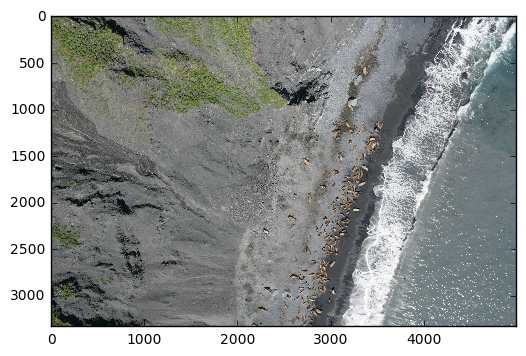

In [86]:
# load image
numpyArray = np.array(Image.open("../01_input/Train/seals/41.jpg"))
plt.imshow(numpyArray)
numpyArray.shape

Found 10 images belonging to 1 classes.


(10L, 3L, 1024L, 1572L)

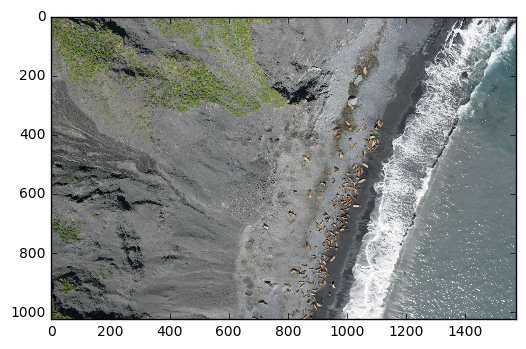

In [120]:
N_Classes = 5
x_dim = 1024
y_dim = 1572
target_size=(x_dim,y_dim)
class_mode='categorical'
path='../01_input/'
dirname = 'Train'
gen=image.ImageDataGenerator()

batches = gen.flow_from_directory(path+dirname,target_size=target_size,class_mode=class_mode, 
                                          shuffle=False, batch_size=1)
totalImages = batches.nb_sample

masks = np.zeros([totalImages,N_Classes,x_dim,y_dim],dtype=np.int32)
images = np.ndarray([totalImages, 3 , x_dim, y_dim ],dtype=np.float32)
numImages = 0

for i in range(totalImages):
        x,y = batches.next()
        images[numImages] = x[0]
        numImages += 1
                        
numImages = 0
plt.imshow(images[numImages].transpose((1,2,0))*255)
images.shape


In [121]:
p = pd.read_csv('../01_input/mask_coordinates.csv')
photos=glob("../01_input/Train/seals/*.jpg")
ids = sorted(list(set([(f.split('\\')[1]) for f in photos])))
numImage = 0
for photo_id in ids:
    numpyArray = np.array(Image.open("../01_input/Train/seals/"+ photo_id))
    x_max,y_max,i = numpyArray.shape
    rows = p.loc[p['filename'] == photo_id ]
    for index, row in rows.iterrows():
        start_x_resized = (row['start_x'] * x_dim / x_max)
        start_y_resized = (row['start_y'] * y_dim / y_max)
        end_x_resized = (row['end_x'] * x_dim / x_max)
        end_y_resized = (row['end_y'] * y_dim / y_max)
        if row['pups']==1:
            Class=0
        if row['adult_females']==1:
            Class=1
        if row['juveniles']==1:
            Class=2
        if row['adult_males']==1:
            Class=3
        if row['subadult_males']==1:
            Class=4 
        for pixel_x in range(start_x_resized,end_x_resized):
               for pixel_y in range(start_y_resized,end_y_resized):
                    if pixel_x < x_dim  and pixel_x > -1:
                        if pixel_y < y_dim and pixel_y > -1:
                            masks[numImage,Class, pixel_x,pixel_y] = 1
    numImage += 1

17262

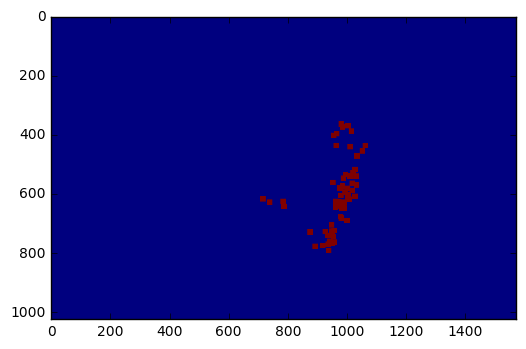

In [122]:
numImages = 0
plt.imshow(masks[numImages,0].transpose((0,1)))
np.sum(masks[numImages,0].transpose((1,0)))

In [7]:
masks.shape

(10L, 1024L, 1572L, 5L)

In [ ]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

In [ ]:
def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [ ]:
def get_unet():
    inputs = Input((3, x_dim, y_dim))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(5, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model


In [ ]:
model = get_unet()
model.fit(images, masks, batch_size=16, nb_epoch=1, verbose=1, shuffle=True)   

In [ ]:
photos=glob("*.jpg")
listings = list(set([f.split('.')[0] for f in photos]))
shuffled_listings = np.random.permutation(listings)
sample_size = int(round(len(listings) * (1/NumberOfFolds),0))

for i in range(int(NumberOfFolds)): 
    os.mkdir('/cp/home/ubuntu/data/folds/fold_'+str(i))
    for listing in shuffled_listings[range(i*sample_size,(i*sample_size)+sample_size)]:
        pics=glob(listing+"_*.jpg")
        for pic in pics:
            os.rename(pic, '/cp/home/ubuntu/data/folds/'+'fold_'+str(i)+'/' + pic)

    #Move photos into directories based on class type 
    s = '/cp/home/ubuntu/data/folds/fold_' + str(i)
    os.chdir(s)
    photos=glob('*.jpg')
    os.mkdir('low')
    os.mkdir('medium')
    os.mkdir('high')
    for photo in photos:
        listing_id = photo.partition("_")[0]
        row = p.loc[p['listing_id'] == int(listing_id) ]
        interest_level = 'NA'
        if len(row)>0:
            interest_level = row['interest_level'].iloc[0]
            os.rename(photo, interest_level + '/' + photo)
    os.chdir('/cp/home/ubuntu/data/photos')

In [110]:
photo_id, Class,x_max,y_max, row['start_x'], row['start_y'], start_x_resized,end_x_resized, start_y_resized,end_y_resized
pixel_x < x_dim  & pixel_x > -1

False

In [111]:
p = pd.read_csv('../01_input/mask_coordinates.csv')
photos=glob("../01_input/Train/seals/*.jpg")
ids = sorted(list(set([(f.split('\\')[1]) for f in photos])))

numImage = 0
photo_id = ids[0]
numpyArray = np.array(Image.open("../01_input/Train/seals/"+ photo_id))
x_max,y_max,i = numpyArray.shape
rows = p.loc[p['filename'] == photo_id ]
row = rows.iloc[0]
start_x_resized = (row['start_x'] * x_dim / x_max)
start_y_resized = (row['start_y'] * y_dim / y_max)
end_x_resized = (row['end_x'] * x_dim / x_max)
end_y_resized = (row['end_y'] * y_dim / y_max)
if row['pups']==1:
    Class=0
if row['adult_females']==1:
    Class=1
if row['juveniles']==1:
    Class=2
if row['adult_males']==1:
    Class=3
if row['subadult_males']==1:
    Class=4 
for pixel_x in range(start_x_resized,end_x_resized):
       for pixel_y in range(start_y_resized,end_y_resized):
            if pixel_x < x_dim  and pixel_x > -1:
                if pixel_y < y_dim and pixel_y > -1:
                    masks[numImage,Class, pixel_x,pixel_y] = 1